# Analyzing NYC High School Data
In this project we are going to analyze relationships between SAT score and demographic factors in New York city public schools.The [SAT](https://en.wikipedia.org/wiki/SAT) or scholastic Aptitude test, is a test that high school seniors in the U.S. take every year.SAT has got three sections,each awarded maximum of `800` points.Colleges use the SAT to determine which students to admit.High average SAt scores are usually indicative of good school.

Ney York City has published data on [student SAT scores](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) by high school, along with additional demographic data sets.
* [SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
* [chool attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt) -  Attendance information for each school in New York City
* [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
* [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) -  Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
* [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) - The percentage of students who graduated, and other outcome information
* [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) - Demographic information for each school
* [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) - Surveys of parents, teachers, and students at each school

## summery of results
Based on the research, these are our findings:
* Schools with bigger share of Hispanic and Black students tend o perform poorly  in SAT.
* High expection in academic by student has got a positive impact in SAT.
* Schools with safer environment tend to produce student that correlate positively with the SAT.Most students in these schools performs really good in SAT.
* Passing in AP test, projects a good perfomance in the SAT.
* Those students where english isn't the native language tend to perform poorly in SAT.

# Read in the data
The data sets we want to deal with are in different format that is in `.csv file format` and `.txt file format`

#### .csv file format

In [1]:
import pandas as pd
import numpy
import re
# we store all the data in csv format in a variable named data_files
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}  #  the dictionary base of the filename as the key,and  corresponding dataframe as its value.
for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys
#### .txt file format

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')

# we combine the two dataframe into one df called survey

survey = pd.concat([all_survey, d75_survey], axis=0)

# we copy the data from the dbn column of survey into a new column in survey called DBN

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]

# filter out the survey to only contains the columns  listed above

survey = survey.loc[:,survey_fields]

# we then Assign the dataframe survey to the key survey in the dictionary data

data["survey"] = survey

# Add DBN columns


In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric
After converting the columns to numeric, we will have to parse the latitude and longitude coordinates for each school as it will enable us to map the schools and uncover any geographic patterns in the data

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

# create a new column called sata_score

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

# this function pull out the latitude

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

# this function pull out the longitude

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

# we then create new columns, lat and lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets
By condensing the datasets, we will do the following : 

i For `class_size` df ,we will have to;

* Create a new variable called class_size, and assign the value of `data["class_size"]` to it.
* Filter class_size so the `GRADE`  column only contains the value `09-12`. 
* Filter class_size so that the `PROGRAM TYPE ` column only contains the value `GEN ED`
* Find the average values for each column associated with each `DBN` in `class_size`

ii. For the dataframe ,`demographics` we will;

* Filter `demographics`, only selecting rows in `data["demographics"]` where schoolyear is 20112012

iii. For the dataframe,`graduation` we will;

* Only select rows where the `Cohort column` equals `2006` and  where the `Demographic column` equals `Total Cohort`


In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)

# this reset the index to make DBN a column again

class_size.reset_index(inplace=True)

# we sign the dataframe back to our dictionary

data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets
Both the `ap_2010` and the `graduation` data sets have many missing `DBN values`, so we'll use a `left join` when we merge the `sat_results` data set with them.

we will then have to merge `class_size`, `demographics`, `survey`, and `hs_directory` into `combined`(the new dataframe) but this time using the inner join.

After combining the files, we will fill in the missing values


In [7]:
# merging the files

combined = data["sat_results"]

# merging using left join

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

# merging using inner join

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")
    
# fill in the missing values with means of the respectives column

combined = combined.fillna(combined.mean())

# Fill in any remaining missing values in combined with 0

combined = combined.fillna(0)

# Add a school district column for mapping
Mapping the statistics out on a school district level might be an interesting way to analyze them. Adding a column to the data set that specifies the school district will help us accomplish this.

The school district is just the first two characters of the `DBN`

In [8]:
# this function extracts the first two characters of the DBN and returns them

def get_first_two_chars(dbn):
    return dbn[0:2]

# We ten add a new column that specify school district

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

In [9]:
# descriptive names
column_name={
"dbn":"School identification code",
"N_p":"NUMBER OF RESPONDENTS_Parents",
"N_s":"NUMBER OF RESPONDENTS_Students",
"N_t":"NUMBER OF RESPONDENTS_Teachers",
"aca_p_11":"Academic expectation score from Parent's response",
"aca_s_11":"Academic expectation score from Student's response",
"aca_t_11":"Academic expectation score from Teacher's response",
"aca_tot_11":"Academic expectation score Total",
"com_p_11":"Communication score from Parent's response",
"com_s_11":"Communication score from Student',s response",
"com_t_11":"Communication score from Teacher' response",
"com_tot_11":"Communication score Total",
"eng_p_11":"Engagement score from Parent's response",
"eng_s_11":"Engagement score from Student's response",
"eng_t_11":"Engagement score from Teacher's response",
"eng_tot_11":"Engagement score Total",
"rr_p":"Resonse rate_Parents",
"rr_s":"Resonse rate_Students",
"rr_t":"Resonse rate_Teachers",
"saf_p_11":"Safety and Respect score from Parent's response",
"saf_s_11":"Safety and Respect score from Students's response",
"saf_t_11":"Safety and Respect score from Teacher's response",
"saf_tot_11":"Safety and Respect score Total"
}
col_df =pd.DataFrame({"description":column_name})
col_df

,description
N_p,NUMBER OF RESPONDENTS_Parents
N_s,NUMBER OF RESPONDENTS_Students
N_t,NUMBER OF RESPONDENTS_Teachers
aca_p_11,Academic expectation score from Parent's response
aca_s_11,Academic expectation score from Student's resp...
aca_t_11,Academic expectation score from Teacher's resp...
aca_tot_11,Academic expectation score Total
com_p_11,Communication score from Parent's response
com_s_11,"Communication score from Student',s response"
com_t_11,Communication score from Teacher' response


# Find correlations
Correlations tell us how closely related two columns are.We will therefore do the following;

* apply the method on the `combined` dataframe to find all possible correlations. 
* Assign the result to `correlations`
* Filter correlations so that it only shows correlations for the column `sat_score`

In [10]:
# we apply the method on the combined df

correlations = combined.corr()

# we filter out correlations

correlations = correlations["sat_score"]
print(correlations[:30])
print(correlations[30:])

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

From the output we can confirm that;

* `SAT Critical Reading Avg. Score`, `SAT Math Avg. Score`, `SAT Writing Avg. Score`, and `sat_score` are strongly correlated with `sat_score`
* `total_enrollment` has a strong positive correlation with `sat_score`.which seems to be ironical, because our expectation was that smaller schools where student have more attention to have higher scores.However it's looks like the opposite is true, larger schools tend to perform better.
* Both the percentage of females (`female_per`) and number of females (`female_num`) at a school correlate **positively** with `SAT score`, whereas the percentage of males (`male_per`) and the number of males (`male_num`) correlate **negatively**.This implies that women do better than men in the SAT.
* Student ratings of school academic standards (`aca_s_11`) correlate with `sat_score`
* Teacher and student ratings of school safety (`saf_t_11`, and `saf_s_11`) correlate with `sat_score`.
* The percentage of English language learners at the school (`ell_percent`, `frl_percent`) has a **strong negative** correlation with `SAT scores`
* There is significant **racial inequality** in SAT scores (`white_per`, `asian_per`, `black_per`, ```hispanic_per```)

# Plotting survey correlations

We can now visualize the survey column(`survey_fields`) in our combined dataframe on how it corrolate with SAT score

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

# diplay the survey column
print(survey_fields)

['DBN', 'rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11', 'saf_t_11', 'com_t_11', 'eng_t_11', 'aca_t_11', 'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11', 'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']


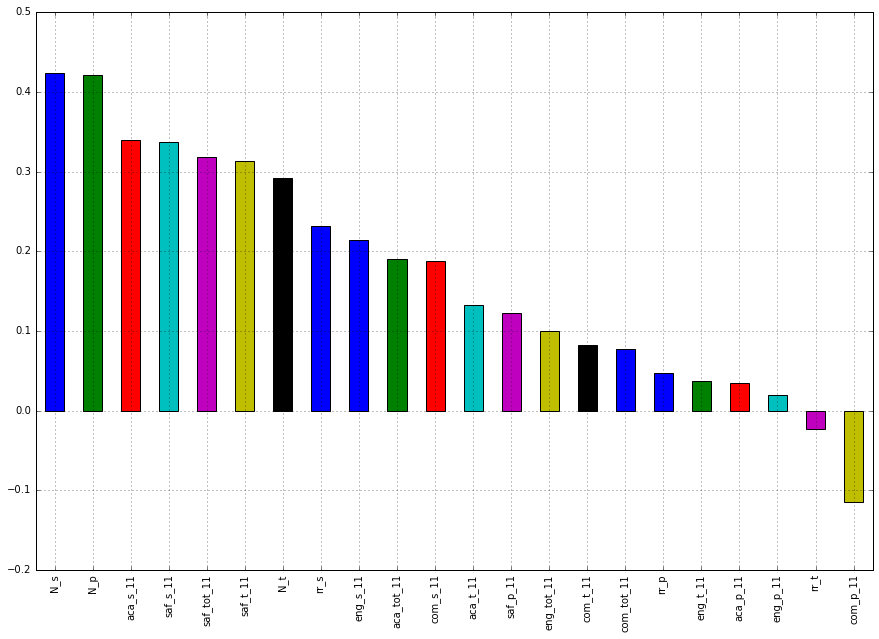

In [12]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.

survey_fields.remove("DBN")

# we make a bar plot of the correlations between survey_field and sat_scores

combined.corr()["sat_score"][survey_fields].sort_values(ascending = False).plot.bar(grid = "on",figsize = (15,10))
plt.show()

From the ouput we can confirm that;

* Number of students,teachers,parents that is `N_s`,`N_t`,`N_p` respectively, correlate strongly positive with SAT scores.
* Also,`saf_t_11` and `saf_s_11`, which measure how teachers and students perceive safety at school, correlated highly with `sat_score`
* We have only two survey fields that show negatve correlation, that is Communication score from Parent's response(`com_p_11`) and Resonse rate_Teachers(`rr_t`)
* it's also so interesting that `rr_s` the student respose rate correlate positvely with SAT scores.This may be so because in many cases, student who are more likely to fill out the survey may be also more likely to perfrom better academically.

## Exploring Safety scores
We will dig into relationship a bit more, and try to figure out which schools have low safety scores

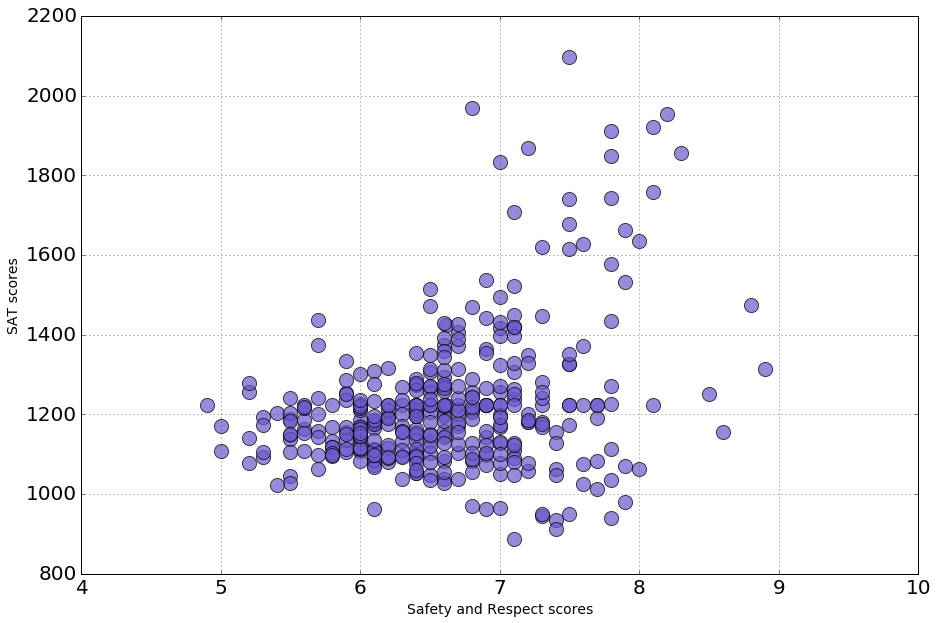

In [13]:
# making scatter plot 
combined.plot.scatter(
    ["saf_s_11"],
    ["sat_score"],
    s = 200,
    figsize = (15,10),
    fontsize = 20,
    alpha = 0.7,
    color = "slateblue",
    grid = "on")
plt.xlabel('Safety and Respect scores', size=14)
plt.ylabel('SAT scores', size=14)
plt.show()

Observations;

* It seems to be a correlation between SAT score and saf_s_11,safety scores.
* There are few schools with extreme SAT scores and safety score.

*  Non of the schools with safety score less than 6 have sat score that equals 1600 or more.


## Safety and Respect Scores by Borough
We are going to compute the average score for each borough

In [14]:
combined.groupby("boro").agg(numpy.mean)["saf_tot_11"].sort_values()


boro
Brooklyn         7.129245
Staten Island    7.200000
Bronx            7.322581
Queens           7.387500
Manhattan        7.473333
Name: saf_tot_11, dtype: float64

We can see that, Brooklyn is the least safety place where as, Manhattan is the most secured place. 

## Racial Differences In SAT Scores
Next we are going to plot out correlations between racial differences and SAT scores.

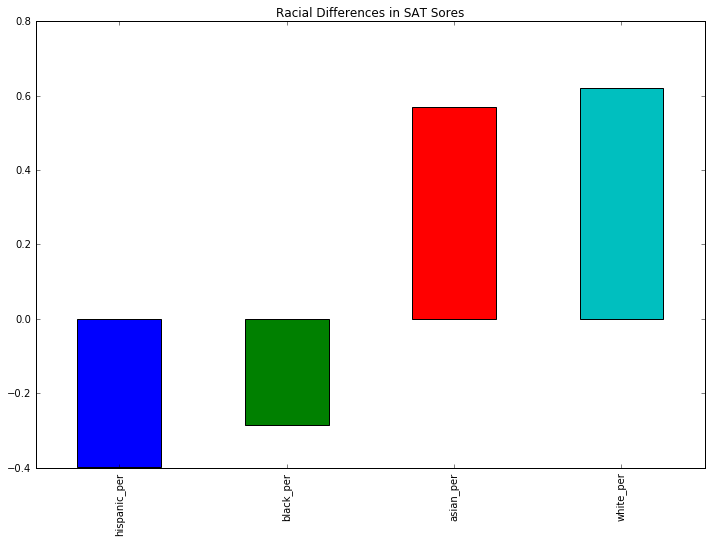

In [15]:
# store the columns in a variable

racial_difference = ["white_per","asian_per","black_per","hispanic_per"]

# plotingg

combined.corr()["sat_score"][racial_difference].sort_values().plot.bar(
    figsize = (12,8),title = "Racial Differences in SAT Sores")

We can see that higher percentage of the whites and the Asian students correlate positively with the SAT scores. Racial diffirence has clearly emerged because of the higher percentage of the Blacks students  and Hispanic students whom correlate negatively with the SAT scores. This may be due to insufficient funding for schools for certain aresas more likely to have a higher percentage of black or hispanic students.

## EXploring schools with low SAT score
To explore the schools with low SAT scores, we will have to make scatter plot

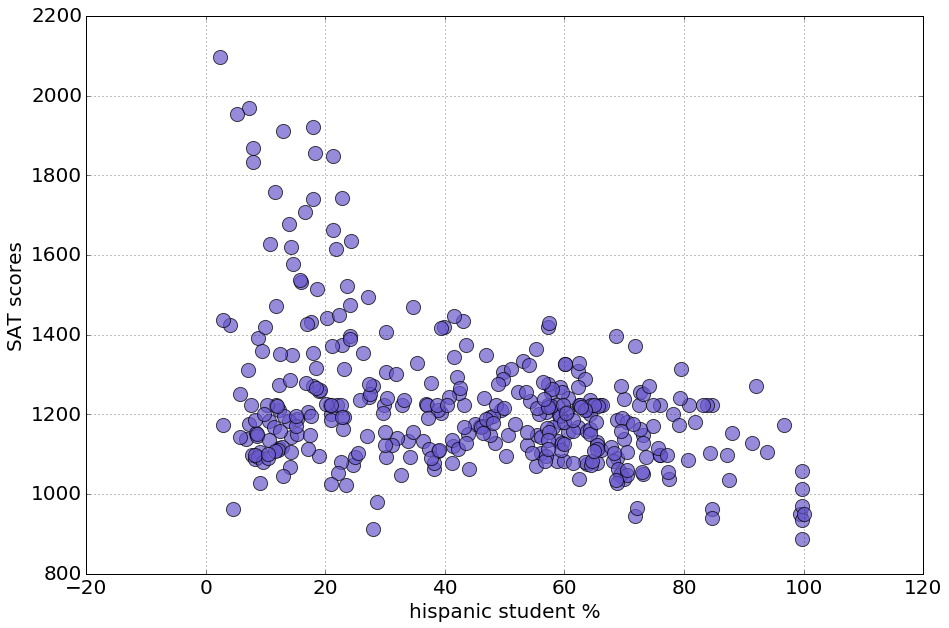

In [16]:
# scatter plot hispanic_per vs sat_score

combined.plot.scatter("hispanic_per","sat_score",
                      s = 200,figsize = (15,10),
                      fontsize = 20,
                      alpha = 0.7,
                      color = "slateblue",
                      grid = "on")
plt.xlabel('hispanic student %', size=20)
plt.ylabel('SAT scores', size=20)

From the output we can confirm that;
* There is a strong negative correlation between Hispanic student and the SAT scores.
* For all the schools where the percentage is higher than 40, The maximum SAT score is ** Never ** higher than 1500.
* Also the schools where the percentage is between 0 and 20 , the minimum SAT score is always 900 and above.

In [17]:
# hispanic student that records above 95 %.

hisp_max = combined[combined["hispanic_per"] > 95]["SCHOOL NAME"]
hisp_max

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

From google research we find that most of these schools are immigrant schools to US recently.The school is committed to assisting students in maintaining the richness of their native language while teaching English so as to best equip them to navigate our current multicultural world, and that may be the reason why they don't perform well in SAT results.

In [18]:
# hispanic student where schools record less than 10%

hispanic_less_10 = combined[(combined["hispanic_per"] < 10) & (combined["sat_score"]> 1800)]["SCHOOL NAME"]       
hispanic_less_10


37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test

## Gender difference  in SAT scores
Next is to plot out the correlations between percentage of each gender  at school wit SAt results

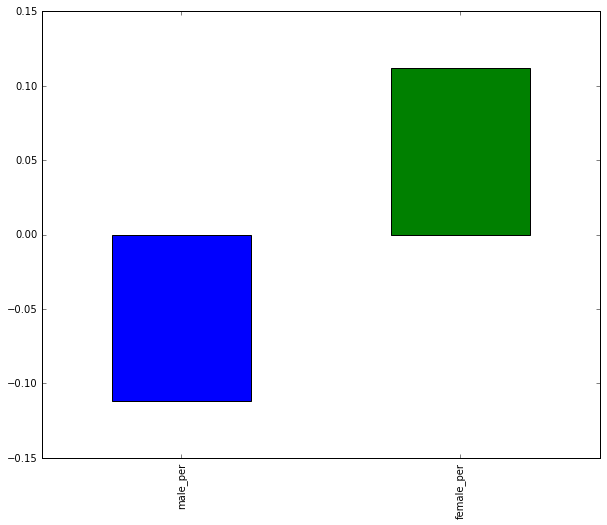

In [19]:
# create a list named gender to hold gender percentages

gender = ["male_per","female_per"]

# ploting the correlation

combined.corr()["sat_score"][gender].plot.bar(
    figsize =(10,8))

From the output, we can confirm that females percentage corralate positively with SAT scores, While males percentage correlate negatively with SAT scores. This indicates that females do better than males in SAT scores.

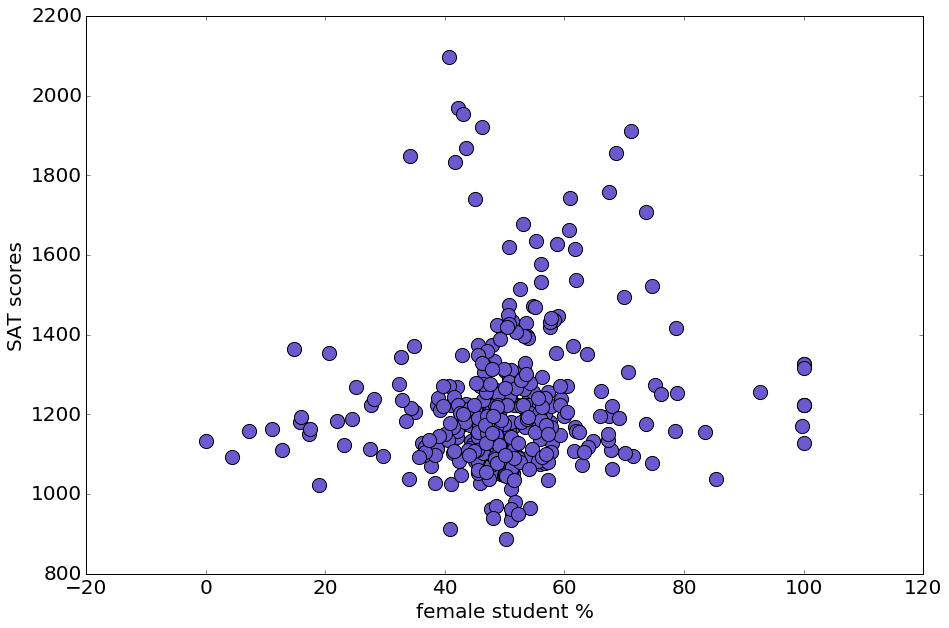

In [20]:
# scatter plot of female_per vs sat_score

combined.plot.scatter("female_per","sat_score",
                     figsize = (15,10),
                     s = 200,
                     color = "slateblue",
                    fontsize = 20)
plt.xlabel("female student %", size = 20)
plt.ylabel("SAT scores", size = 20)

Basing our observation from scatter plots, there is no that real correlation between the `sat_score` and `female_per`.Though schools with percentage of female between 60 and 80 records  a high SAT scores with some scores higher than 1800.

In [21]:
# schools with female percentage greater than 60% and having SAT score greater than 1700

combined[(combined["female_per"]>60) & (combined["sat_score"]>1700)]["SCHOOL NAME"]

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Reserch from google shows that,most of these schools appears to be very selective liberal arts schools that have high academic standards.

## AP Exam Score And SAT scores
In the U.S., high school students take Advanced Placement (AP) exams to earn college credit.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship.

Because `total_enrollment` is highly correlated with `sat_score`, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam


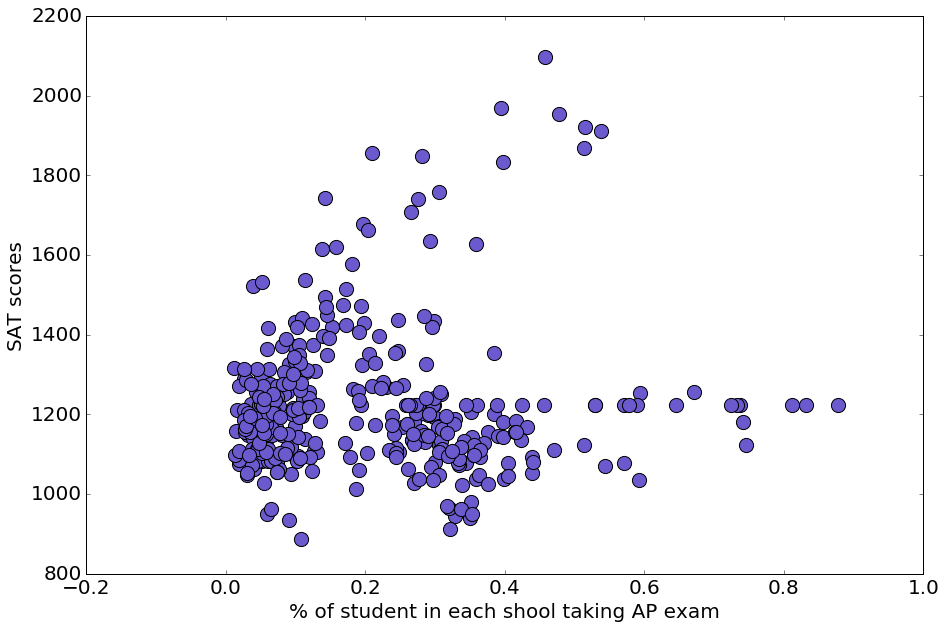

In [22]:
# creating ap_per column by getting % of student in each school that took an AP exam.

combined["ap_per"] = combined["AP Test Takers "]/combined["total_enrollment"]

# scatter plot of ap_per vs. sat_score

combined.plot.scatter("ap_per","sat_score",
                     figsize = (15,10),
                     s = 200,
                     fontsize = 20,
                     color = "slateblue")
plt.xlabel("% of student in each shool taking AP exam",size = 20)
plt.ylabel("SAT scores" , size = 20)           




Its seems like there is a positive correlation though not strong of the percentage of students in a school who take the AP exam with that of SAT scores.

## Conclusion

In this project, we cleaned,combined,visualized and analyzed different datasets containing informations about SAT scores and demographics in NYC public high schools.We have dig deep into SAT scores trying to find out how it correlates with diffirent fields.And here are the findings;

* Shools with high percentage of females tend to do better in SAT compared to those with higer percentage of men. This indicates that female do better in SAT compared to men
* White and Asian students tend to do better in SAT compared to Hispanic and Black students.Poor perfomance of Hispanic students, is caused by recent immigartion in US.
* Students who always engage positively with the survey also do well in SAT.
* Those who didn't do well in AP tests tend to do poorly in SAT tests as well
* We also confirm that, schools that do enjoy safety, ignited a good perfomaance in SAT.
